In [39]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

In [40]:
url = "https://raw.githubusercontent.com/AHMerrill/unstructured-data-2/main/reviews_final.csv"
reviews = pd.read_csv(url)
display(reviews.head())
display(reviews.shape)

,beer,brewery,style,style_id,average_user_rating,username,user_rating,delta_from_average,look,smell,taste,feel,overall,date,review_text,brewery_id,beer_id,page_start
0,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,MadMadMike,4.53,0.07,4.25,4.25,4.75,4.50,4.50,"Jul 29, 2025","In bottle, on tap, at the brewery - anywhere t...",17981,98020,0
1,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Rug,4.06,-0.40,4.00,4.25,4.00,4.00,4.00,"Jul 01, 2022",Unknown vintage\n\nSome more BIF heat from the...,17981,98020,0
2,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,BFCarr,4.43,-0.03,4.25,4.25,4.50,4.50,4.50,"Apr 02, 2021",Pours dark brown with a thin tan head. Aroma c...,17981,98020,0
3,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Dfeinman1,4.23,-0.23,4.00,4.75,4.00,4.00,4.25,"Mar 02, 2021",Such a tasty beer. Perfect mouthfeel and carbo...,17981,98020,0
4,Caffè Americano,Cigar City Brewing,American Imperial Stout,157,4.46,Radome,4.54,0.08,4.75,4.50,4.50,4.75,4.50,"Jan 02, 2021",Poured from a bomber bottle into a Duvel glass...,17981,98020,0


(17863, 18)

## We used TF-IDF to get the top words.  TF-IDF is still BoW (in the sense that it's orderless), just down-weighting words that appear everywhere.  We used TF-IDF only to pick out attributes.  Later we'll switch to count-vectorizer.

In [41]:
# Use scikit-learn’s TfidfVectorizer
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",    # basic English stopwords only
    token_pattern=r"(?u)\b[a-zA-Z]{3,}\b",  # only words with ≥3 letters
    max_df=0.8,              # ignore terms in >80% of docs (too common)
    min_df=5,                # keep only words that appear in ≥5 reviews
    max_features=10000        # limit vocabulary size
)

X_tfidf = vectorizer.fit_transform(reviews["review_text"].astype(str))

print("Shape:", X_tfidf.shape)

Shape: (17863, 7011)


In [42]:
# Average TF-IDF across all reviews
avg_tfidf = X_tfidf.mean(axis=0).A1
vocab = vectorizer.get_feature_names_out()

top_idx = np.argsort(avg_tfidf)[::-1][:500]
top_words = [(vocab[i], avg_tfidf[i]) for i in top_idx]

## Then we pasted the top 500 words into chatGPT and asked it to pick out an attribute list

In [43]:
# ==================================================
# Master list of attribute keywords mined from corpus
# ==================================================
ATTRIBUTES = [
    # Hop-forward / bitter
    "hoppy", "hops", "bitter", "bitterness", "dank", "pine", "piney", "resin", "resinous", "floral",

    # Citrus & fruit
    "citrus", "grapefruit", "orange", "lemon", "tangerine", "mango", "pineapple", "peach",
    "tropical", "juicy", "citrusy", "apricot", "papaya", "guava",

    # Roast / cocoa / coffee
    "roasted", "roasty", "roast", "coffee", "espresso", "chocolate", "cocoa", "mocha",

    # Caramel / dessert-like
    "vanilla", "caramel", "toffee", "maple", "molasses", "fudge", "dessert", "candied",

    # Sour / tart / funk
    "sour", "tart", "tartness", "acidity", "acidic", "funky", "barnyard", "lambic",

    # Body / mouthfeel
    "smooth", "creamy", "silky", "velvety", "chewy", "oily", "sticky", "viscous", "dense",

    # Crisp / refreshing
    "crisp", "dry", "refreshing", "clean", "bright",

    # Spice / herbal
    "spicy", "pepper", "cinnamon", "herbal",

    # Strength / heat
    "strong", "boozy", "warming", "warmth",

    # Appearance
    "hazy", "cloudy", "clear"
]


## We then collapsed / mapped some of our attributes so that users input is more regularized

In [44]:
# =====================================
# Canonical attribute mapping dictionary
# =====================================

ATTR_MAP = {
    # Hop-forward / bitter
    "hoppy": "hoppy",
    "hops": "hoppy",
    "bitter": "bitter",
    "bitterness": "bitter",
    "dank": "dank",
    "pine": "pine",
    "piney": "pine",
    "resin": "resin",
    "resinous": "resin",
    "floral": "floral",

    # Citrus & fruit
    "citrus": "citrus",
    "citrusy": "citrus",
    "grapefruit": "grapefruit",
    "orange": "orange",
    "lemon": "lemon",
    "tangerine": "tangerine",
    "mango": "mango",
    "pineapple": "pineapple",
    "peach": "peach",
    "tropical": "tropical",
    "juicy": "juicy",
    "apricot": "apricot",
    "papaya": "papaya",
    "guava": "guava",

    # Roast / cocoa / coffee
    "roast": "roasty",
    "roasted": "roasty",
    "roasty": "roasty",
    "coffee": "coffee",
    "espresso": "coffee",
    "chocolate": "chocolate",
    "cocoa": "chocolate",
    "mocha": "chocolate",

    # Caramel / dessert-like
    "vanilla": "vanilla",
    "caramel": "caramel",
    "toffee": "toffee",
    "maple": "maple",
    "molasses": "molasses",
    "fudge": "fudge",
    "dessert": "dessert",
    "candied": "candied",

    # Sour / tart / funk
    "sour": "sour",
    "tart": "sour",
    "tartness": "sour",
    "acidity": "sour",
    "acidic": "sour",
    "funky": "funky",
    "barnyard": "funky",
    "lambic": "lambic",

    # Body / mouthfeel
    "smooth": "smooth",
    "creamy": "creamy",
    "silky": "silky",
    "velvety": "velvety",
    "chewy": "chewy",
    "oily": "oily",
    "sticky": "sticky",
    "viscous": "viscous",
    "dense": "dense",

    # Crisp / refreshing
    "crisp": "crisp",
    "dry": "dry",
    "refreshing": "refreshing",
    "clean": "clean",
    "bright": "bright",

    # Spice / herbal
    "spicy": "spicy",
    "pepper": "pepper",
    "cinnamon": "cinnamon",
    "herbal": "herbal",

    # Strength / heat
    "strong": "strong",
    "boozy": "boozy",
    "warming": "warm",
    "warmth": "warm",

    # Appearance
    "hazy": "hazy",
    "cloudy": "cloudy",
    "clear": "clear"
}


## Also created some expansions.  This way, if a user types "citrus," it also expands the search into various types of citrus, so the search will be more robust accross the reviews.  This list came from chatGPT recommendations.

In [45]:
# --- Query-time expansion (Option B) ---
QUERY_EXPANSION = {
    "citrus": ["citrus","orange","lemon","grapefruit","tangerine","lime","zest","zesty","rind","pith"],
    "tropical": ["tropical","mango","pineapple","papaya","guava","passionfruit","lychee","coconut"],
    "fruity": ["fruity","fruit","fruits","peach","apricot","nectarine","berry","berries",
               "raspberry","blueberry","blackberry","cherry","grape","plum","raisin","raisins"],
    "hoppy": ["hoppy","hops","dank","resin","resiny","resinous","pine","piney","floral","herbal","grassy","earthy"],
    "bitter": ["bitter","bitterness","astringent"],
    "herbal": ["herbal","herbaceous","grassy","earthy","tea"],
    "spicy": ["spicy","pepper","peppery","peppercorn","cinnamon","clove","coriander","ginger","cardamom"],
    "roasty": ["roasty","roast","roasted","coffee","espresso","smoke","smoky","smokey","char","charred","ashy","burnt"],
    "chocolate": ["chocolate","cocoa","cacao","mocha","brownie","fudgy","fudge"],
    "coffee": ["coffee","espresso","latte","americano","mocha"],
    "caramel": ["caramel","butterscotch","toffee","praline","brown sugar","caramelized","maple","molasses","syrup"],
    "dessert": ["dessert","candied","marshmallow","pastry","cake","cookie","vanilla"],
    "malty": ["malty","malt","malts","bready","bread","biscuit","biscuity","toasty","toasted","cracker","grainy","nutty"],
    "sour": ["sour","tart","tartness","acidic","acidity","pucker","puckering","lemony","vinegar","acetic","lactic","zippy"],
    "funky": ["funky","barnyard","brett","bretty","brettanomyces","horseblanket","wild","lambic"],
    "crisp": ["crisp","snappy","brisk","clean","bright"],
    "dry": ["dry","brut","bone-dry"],
    "refreshing": ["refreshing","spritz","sprightly","lively","effervescent","bubbly","tingly","prickly","carbonated"],
    "mouthfeel": ["smooth","creamy","silky","velvety","pillowy","soft","fluffy","chewy","oily","slick",
                  "sticky","viscous","syrupy","dense","thin","thick","watery"],
    "boozy": ["boozy","alcohol","alcoholic","hot","heat","warming","warm","strong","imperial"],
    "barrel": ["barrel","barrels","barrel-aged","barrelaged","bourbon","whiskey","rye","brandy","oak","oaky","vanillin"],
    "hazy": ["hazy","haze","murky","opaque","cloudy"],
    "clear": ["clear","brilliant","limpid"]
}

def build_expanded_query(user_tokens, attr_map, expansion_dict):
    """Normalize -> expand umbrellas -> re-normalize -> dedupe."""
    norm = [attr_map.get(t.lower(), t.lower()) for t in user_tokens]
    expanded = [w for t in norm for w in expansion_dict.get(t, [t])]
    expanded_norm = sorted({attr_map.get(w.lower(), w.lower()) for w in expanded})
    unigrams = {w for w in expanded_norm if " " not in w}
    bigrams  = {w for w in expanded_norm if " " in w}
    return " ".join(expanded_norm), expanded_norm, unigrams, bigrams


## Then the user inputs their preferences

In [46]:
# ==============================
# Customer preferences (edit me)
# ==============================
def normalize_attribute(token: str) -> str:
    return ATTR_MAP.get(token.lower(), token.lower())

# Example for customer input
CUSTOMER_ATTRIBUTES = ["Hops", "CRISP", "citrusy"]
CUSTOMER_ATTRIBUTES = [normalize_attribute(a) for a in CUSTOMER_ATTRIBUTES]
print(CUSTOMER_ATTRIBUTES)
# ['hoppy', 'crisp', 'citrus']

# Example for reviews (tokenize then normalize)
# review_tokens = review_text.split()
# normalized_tokens = [normalize_attribute(t) for t in review_tokens]


['hoppy', 'crisp', 'citrus']


## We also normalized the review_text field so that the words there will better match the user input normalization

In [47]:
import re

def normalize_attribute(token: str) -> str:
    return ATTR_MAP.get(token.lower(), token.lower())

def normalize_review(text: str) -> str:
    """
    1. Lowercase
    2. Tokenize on spaces (you can get fancier later if needed)
    3. Replace tokens using ATTR_MAP if present
    4. Rejoin into normalized review text
    """
    if not isinstance(text, str):
        return ""
    tokens = re.findall(r"[a-zA-Z]+", text.lower())  # keep only words
    norm_tokens = [normalize_attribute(t) for t in tokens]
    return " ".join(norm_tokens)

# Create a normalized text column just for vectorization
reviews["review_norm"] = reviews["review_text"].apply(normalize_review)

# Check a few before/after
for i in range(3):
    print("RAW:", reviews["review_text"].iloc[i][:120])
    print("NORM:", reviews["review_norm"].iloc[i][:120])
    print("---")


RAW: In bottle, on tap, at the brewery - anywhere this classic gem shows up, got to get a pull. High quality stuff right here
NORM: in bottle on tap at the brewery anywhere this classic gem shows up got to get a pull high quality stuff right here the c
---
RAW: Unknown vintage

Some more BIF heat from the legendary @Eziel! I’m starting to work my way up to the more acclaimed bott
NORM: unknown vintage some more bif heat from the legendary eziel i m starting to work my way up to the more acclaimed bottles
---
RAW: Pours dark brown with a thin tan head. Aroma certainly coffee and some booze notes. Taste is mostly booze (whiskey/bourb
NORM: pours dark brown with a thin tan head aroma certainly coffee and some booze notes taste is mostly booze whiskey bourbon 
---


## For the recommender, we switched to count-vectorizer.  That way each word is represented as a vector of word counts, averaged at the beer level.  That count-vector is then compared to the user's attribute vector with cosine similarity

## We then used VADER for sentiment analysis.  It's built into nltk and was constructed from social media & review-style data, so it should do ok with slang and intensifiers like "super-hoppy"

## VADER will produce a sentiment score, and then that is used with SENTIMENT_WEIGHT to produce a final score

## In that way, cosine similarity is combined with sentiment to get a final score (i.e. user attributes will not be matched to a beer that has poor sentiment)

## $$
\text{final}
= \text{cosine} \times \left((1-w) + w \cdot \frac{\text{sentiment} + 1}{2}\right)
$$



In [48]:
# ===============================================================
# Recommender (Count BoW with unigrams+bigrams) + Cosine + VADER
# Assumes already defined above:
#   - ATTR_MAP, QUERY_EXPANSION, build_expanded_query
#   - reviews['review_norm'] (normalized corpus)
#   - CUSTOMER_ATTRIBUTES (user's 3 attributes, any case)
# Columns used: beer, brewery, style, average_user_rating
# ===============================================================

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- knobs ---
USE_BINARY = False         # False: counts, True: presence-only
MIN_DF = 5                 # drop very rare ngrams
SENTIMENT_WEIGHT = 0.5     # 0..1 sentiment boost
TOP_K = 23                 # show Top 3 + next 20
TOP_UNIGRAMS_PER_BEER = 5  # show top 5 single-word drivers

# 1) Build expanded query from the user's attributes
query_doc, expanded_norm, expanded_unigrams, expanded_bigrams = build_expanded_query(
    CUSTOMER_ATTRIBUTES, ATTR_MAP, QUERY_EXPANSION
)

# 2) Vectorize reviews with unigrams + bigrams (corpus vocabulary)
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    binary=USE_BINARY,
    min_df=MIN_DF
)
X_bow = vectorizer.fit_transform(reviews["review_norm"].astype(str))
vocab = vectorizer.get_feature_names_out()

# 3) Collapse review vectors into BEER-level centroids (mean to avoid popularity bias)
grp = reviews.groupby("beer", sort=False).indices
beer_keys = list(grp.keys())
beer_to_row = {b: i for i, b in enumerate(beer_keys)}
beer_mat = np.vstack([X_bow[idxs].mean(axis=0).A1 for idxs in grp.values()])  # (n_beers x |vocab|)

# 4) Vectorize the expanded user query in the same space and compute cosine similarity
qvec = vectorizer.transform([query_doc])
cosine_scores = cosine_similarity(beer_mat, qvec).ravel()

# 5) Sentiment (VADER): compute once if missing, then average per beer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
if "_sentiment" not in reviews.columns:
    try:
        _ = SentimentIntensityAnalyzer()
    except:
        nltk.download("vader_lexicon", quiet=True)
    sia = SentimentIntensityAnalyzer()
    reviews["_sentiment"] = reviews["review_norm"].map(lambda t: sia.polarity_scores(t)["compound"])

beer_sent = reviews.groupby("beer")["_sentiment"].mean().reindex(beer_keys).values
sent_pos = (beer_sent + 1.0) / 2.0  # [-1,1] -> [0,1]
final_score = cosine_scores * ((1 - SENTIMENT_WEIGHT) + SENTIMENT_WEIGHT * sent_pos)

# 6) Assemble results table
meta = (reviews.groupby("beer")[["brewery","style","average_user_rating"]]
        .first()
        .reset_index())

results = (pd.DataFrame({
            "beer": beer_keys,
            "cosine": cosine_scores,
            "sentiment_mean": beer_sent,
            "final_score": final_score
          })
          .merge(meta, on="beer", how="left")
          .sort_values("final_score", ascending=False)
          .reset_index(drop=True))

# 7) Attribute coverage over expanded tokens only (not full vocab)
expanded_in_vocab = [t for t in expanded_norm if t in vocab]
exp_idx = np.array([np.where(vocab == t)[0][0] for t in expanded_in_vocab], dtype=int) if expanded_in_vocab else np.array([], dtype=int)
results["attr_dims_nonzero"] = (beer_mat[:, exp_idx] > 0).sum(axis=1) if exp_idx.size else 0

# 8) Top-5 single-word drivers (unigrams from expanded query) for each shown beer
tok2idx = {tok: i for i, tok in enumerate(vocab)}
relevant_uni = np.array([tok2idx[t] for t in expanded_unigrams if t in tok2idx], dtype=int)

def top_k_unigrams_for_beer(beer_name, k=5):
    if relevant_uni.size == 0:
        return ""
    row_idx = beer_to_row[beer_name]
    vals = beer_mat[row_idx, relevant_uni]
    if not np.any(vals):
        return ""
    topk = np.argsort(vals)[::-1][:k]
    return ", ".join([f"{vocab[relevant_uni[i]]}:{vals[i]:.3f}" for i in topk if vals[i] > 0])

results["rank"] = np.arange(1, len(results) + 1)
top = results.head(TOP_K).copy()
top["top_5_unigrams"] = top["beer"].map(lambda b: top_k_unigrams_for_beer(b, TOP_UNIGRAMS_PER_BEER))

display_cols = ["rank","beer","brewery","style",
                "final_score","cosine","sentiment_mean",
                "attr_dims_nonzero","average_user_rating","top_5_unigrams"]
top_table = top[display_cols]
top_table


,rank,beer,brewery,style,final_score,cosine,sentiment_mean,attr_dims_nonzero,average_user_rating,top_5_unigrams
0,1,Double Dry Hopped Congress Street,Trillium Brewing Company,American Pale Ale,0.110354,0.122273,0.610097,6,4.59,"orange:0.793, hoppy:0.552, citrus:0.534, grape..."
1,2,Bodhi,Columbus Brewing Company,Imperial IPA,0.108733,0.115798,0.755934,3,4.46,"citrus:0.690, pine:0.630, hoppy:0.500, grapefr..."
2,3,Double Dry Hopped All Citra Everything,Other Half Brewing - Center Street,New England IPA,0.106477,0.115098,0.700390,5,4.49,"citrus:0.788, orange:0.707, grapefruit:0.394, ..."
3,4,In Perpetuity,Tree House Brewing Company,Sweet / Milk Stout,0.103564,0.112641,0.677635,7,4.52,"orange:0.779, citrus:0.766, hoppy:0.351, grape..."
4,5,King Sue - Double Dry-Hopped,Toppling Goliath Brewing Company,American Pale Ale,0.103458,0.113406,0.649153,9,4.53,"orange:1.427, citrus:0.933, grapefruit:0.461, ..."
5,6,Double Dry Hopped Double Mosaic Daydream,Other Half Brewing - Center Street,New England IPA,0.101792,0.108492,0.752980,1,4.51,"orange:0.928, citrus:0.594, hoppy:0.420, grape..."
6,7,Abner,Hill Farmstead Brewery,Saison,0.101436,0.110352,0.676809,8,4.63,"orange:0.634, citrus:0.634, hoppy:0.537, pine:..."
7,8,Double Galaxy,Hill Farmstead Brewery,Saison,0.100980,0.110927,0.641286,9,4.59,"orange:0.651, citrus:0.614, hoppy:0.554, grape..."
8,9,Abrasive Ale,Surly Brewing Co.,Russian Imperial Stout,0.100519,0.108827,0.694649,16,4.49,"pine:0.896, citrus:0.714, grapefruit:0.662, or..."
9,10,Double Citra®,Hill Farmstead Brewery,Saison,0.099705,0.109982,0.626225,7,4.60,"orange:0.958, hoppy:0.606, citrus:0.606, grape..."


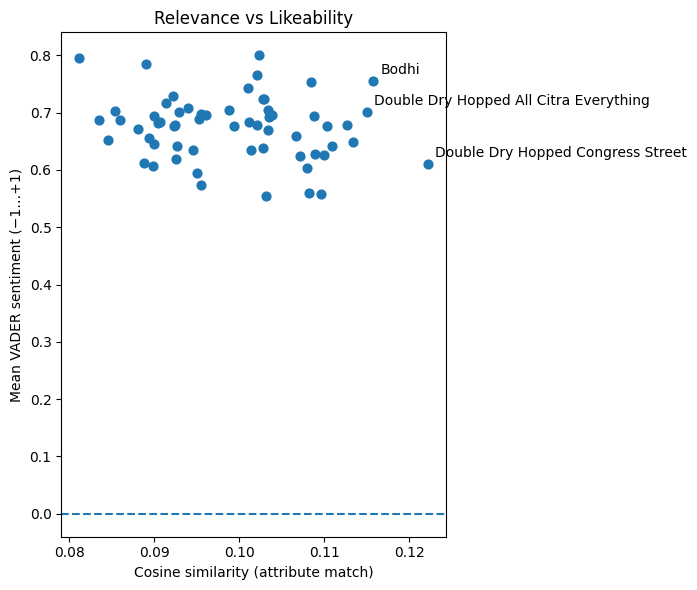

In [49]:
topN = results.head(60).copy()  # wider view
plt.figure(figsize=(7,6))
plt.scatter(topN["cosine"], topN["sentiment_mean"], s=40)

# annotate top 3
for _, r in results.head(3).iterrows():
    plt.annotate(r["beer"], (r["cosine"], r["sentiment_mean"]), xytext=(5,5), textcoords="offset points")

plt.axhline(0, linestyle="--")  # sentiment 0 line
plt.xlabel("Cosine similarity (attribute match)")
plt.ylabel("Mean VADER sentiment (−1…+1)")
plt.title("Relevance vs Likeability")
plt.tight_layout()
plt.show()
